<a href="https://colab.research.google.com/github/mtermor/NTIC_DeepLearning/blob/main/RNN/IMBD_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [4]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels),(test_data, test_labels) = imdb.load_data(num_words = num_words)

17464789/17464789 [==============================] - 0s 0us/step


In [5]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 [==============================] - 0s 0us/step


For transforming an id-sequence to a phrase use get_words

In [6]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [21]:
def vectorize_text_sentence(text, word2int):
  tokens = text.split(' ')
  tokens_id = [word2int.get(tk, 2) for tk in tokens]
  return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [22]:
from collections import Counter

def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [23]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [24]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [25]:
## We can modify the imput vector before the run cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the input of every cell

# Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)

# Last LSTM layer depends in [one to many or many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)

model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_exammple')
print(model.summary())

inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

Model: "rnn_exammple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 8)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            18688     
                                                                 
 lstm_2 (LSTM)               (None, 10, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
Total params: 84736 (331.00 KB)
Trainable params: 84736 (331.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
(32, 64)


### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [26]:
model = keras.Sequential()

# If you create a second layer you must set return_sequences = True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape =(timesteps, features))
)

# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32))) #return_sequences=False by default

# Output
model.add(layers.Dense(10))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 128)           37376     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 79242 (309.54 KB)
Trainable params: 79242 (309.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Loading Data

In [27]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


#### Data Preprocessing

For data preprocessing we first use [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences):
```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```
- **padding**:	'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
- **truncating**:	String, 'pre' or 'post' (optional, defaults to 'pre'): remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.


Our RNN will take sequences of constant length. In our case this length is the `maxlen`

In [28]:
from tensorflow.keras.preprocessing import sequence
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[0 0 1 2 3]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[5 6 7 8 9]]


In [29]:
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, padding='post')
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, truncating='post')
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[1 2 3 0 0]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[1 2 3 4 5]]


In [32]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape: ', x_train_seq.shape)
print('test shape: ', x_test_seq.shape)


train shape:  (25000, 100)
test shape:  (25000, 100)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`.
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [33]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
layers.Embedding(input_dim=3, output_dim=3,
                 input_length=5, embeddings_initializer='identity',
                 trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [40]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
# One-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))
# Complete the model with recurrent layers
model.add(layers.SimpleRNN(16, return_sequences=False))
# Add binary classification
model.add(layers.Dense(1, activation='sigmoid'))

In [42]:
# Set the loss and see the results
model.compile(
    optimizer = 'adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 10s 86ms/step - loss: 0.6507 - accuracy: 0.6313 - val_loss: 0.5923 - val_accuracy: 0.7168
Epoch 2/5
88/88 [==============================] - 6s 68ms/step - loss: 0.5409 - accuracy: 0.7513 - val_loss: 0.5145 - val_accuracy: 0.7664
Epoch 3/5
88/88 [==============================] - 7s 85ms/step - loss: 0.4701 - accuracy: 0.7964 - val_loss: 0.4925 - val_accuracy: 0.7836
Epoch 4/5
88/88 [==============================] - 6s 67ms/step - loss: 0.4195 - accuracy: 0.8258 - val_loss: 0.4485 - val_accuracy: 0.8024
Epoch 5/5
88/88 [==============================] - 7s 84ms/step - loss: 0.3843 - accuracy: 0.8436 - val_loss: 0.4379 - val_accuracy: 0.8028


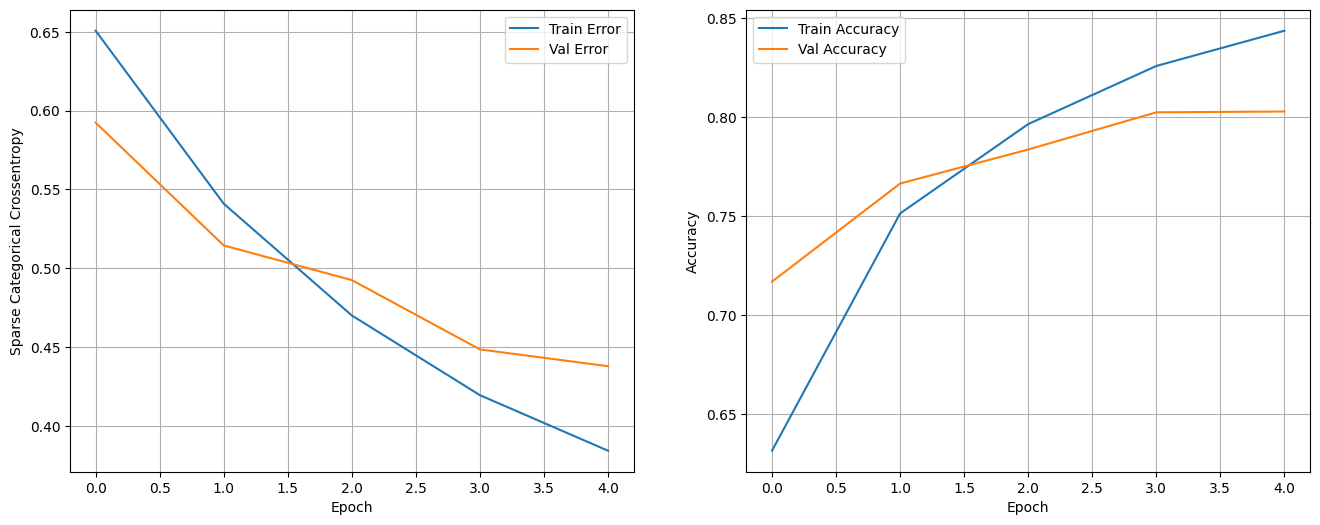

782/782 [==============================] - 9s 11ms/step - loss: 0.4560 - accuracy: 0.7923
Test Loss: 0.45603281259536743
Test Accuracy: 0.7922800183296204


In [43]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [44]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 [==============================] - 9s 11ms/step
Predicted : 1, real : 0, lenght: 285
<START> i'm not one of those folks who <UNK> <UNK> a film based on an old tv show comes out rather i usually run out and see it if i had watched the show and try to get <UNK> but if anyone feels like running down films based on old shows this is <UNK> a so you can actually say something more than just <UNK> <UNK> <UNK> is <UNK> <UNK> and <UNK> at least the original series was <UNK> <UNK> long before anyone knew <UNK> could be so <UNK> making it <UNK> this is just <UNK> <UNK> <UNK> is nice to look at but does nothing else but mood <UNK> and <UNK> around <UNK> on the <UNK> <UNK> <UNK> acting <UNK> in this flick is that <UNK> the dog look for an hour and <UNK> five minutes and <UNK> <UNK> looks like he wants to <UNK> the set but the <UNK> has <UNK> him sure the production is nice with the now seemingly <UNK> <UNK> opening action sequence and <UNK> <UNK> oh and the kids <UNK> and get mad at each ot

#### Making predictioins with new data

In [46]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

# 0 negativo, 1 positivo

1/1 [==============================] - 0s 78ms/step


array([[0.1403],
       [0.9106],
       [0.9097],
       [0.9081],
       [0.1456],
       [0.1451]], dtype=float32)

In [47]:
1.0*(model.predict(x_pred) > 0.5)

1/1 [==============================] - 0s 45ms/step


array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [ ]:
# El modelo no se fija demasiado en el orden de las palabras, si no en el bag of words
# No aprende que "not" niega el sentimiento

### GRU model
Use `keras.layers.GRU`


In [48]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [49]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 5s 30ms/step - loss: 0.6803 - accuracy: 0.5551 - val_loss: 0.6686 - val_accuracy: 0.5760
Epoch 2/5
88/88 [==============================] - 2s 25ms/step - loss: 0.4935 - accuracy: 0.7655 - val_loss: 0.4357 - val_accuracy: 0.7996
Epoch 3/5
88/88 [==============================] - 2s 25ms/step - loss: 0.3915 - accuracy: 0.8252 - val_loss: 0.4501 - val_accuracy: 0.7932
Epoch 4/5
88/88 [==============================] - 3s 31ms/step - loss: 0.3654 - accuracy: 0.8412 - val_loss: 0.4152 - val_accuracy: 0.8172
Epoch 5/5
88/88 [==============================] - 2s 25ms/step - loss: 0.3542 - accuracy: 0.8445 - val_loss: 0.4174 - val_accuracy: 0.8128


In [50]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 4s 5ms/step - loss: 0.4339 - accuracy: 0.7946
Test Loss: 0.4338851273059845
Test Accuracy: 0.7945600152015686


### LSTM model
Use `keras.layers.LSTM`

In [51]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.LSTM(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [52]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 6s 36ms/step - loss: 0.6005 - accuracy: 0.6596 - val_loss: 0.4938 - val_accuracy: 0.7852
Epoch 2/5
88/88 [==============================] - 3s 28ms/step - loss: 0.4260 - accuracy: 0.8146 - val_loss: 0.4212 - val_accuracy: 0.8060
Epoch 3/5
88/88 [==============================] - 2s 28ms/step - loss: 0.3806 - accuracy: 0.8345 - val_loss: 0.4078 - val_accuracy: 0.8152
Epoch 4/5
88/88 [==============================] - 3s 29ms/step - loss: 0.3665 - accuracy: 0.8386 - val_loss: 0.4167 - val_accuracy: 0.8084
Epoch 5/5
88/88 [==============================] - 2s 28ms/step - loss: 0.3574 - accuracy: 0.8447 - val_loss: 0.4092 - val_accuracy: 0.8112


In [53]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 4s 5ms/step - loss: 0.4164 - accuracy: 0.8057
Test Loss: 0.4164426624774933
Test Accuracy: 0.8057199716567993


### Deep model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [54]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [55]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 8s 44ms/step - loss: 0.6298 - accuracy: 0.6180 - val_loss: 0.4694 - val_accuracy: 0.7852
Epoch 2/5
88/88 [==============================] - 3s 30ms/step - loss: 0.4198 - accuracy: 0.8070 - val_loss: 0.4107 - val_accuracy: 0.8148
Epoch 3/5
88/88 [==============================] - 3s 31ms/step - loss: 0.3727 - accuracy: 0.8347 - val_loss: 0.4210 - val_accuracy: 0.8124
Epoch 4/5
88/88 [==============================] - 3s 30ms/step - loss: 0.3634 - accuracy: 0.8409 - val_loss: 0.4230 - val_accuracy: 0.8044
Epoch 5/5
88/88 [==============================] - 3s 33ms/step - loss: 0.3460 - accuracy: 0.8516 - val_loss: 0.4233 - val_accuracy: 0.8076


In [56]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 4s 6ms/step - loss: 0.4337 - accuracy: 0.8023
Test Loss: 0.43369609117507935
Test Accuracy: 0.8022800087928772


### Bidirectional model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` with `keras.layers.Bidirectional`


In [57]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=False)))
model.add(layers.Dense(1, activation='sigmoid'))

In [58]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 10s 57ms/step - loss: 0.6378 - accuracy: 0.6114 - val_loss: 0.4824 - val_accuracy: 0.7692
Epoch 2/5
88/88 [==============================] - 4s 49ms/step - loss: 0.4300 - accuracy: 0.8034 - val_loss: 0.4211 - val_accuracy: 0.8100
Epoch 3/5
88/88 [==============================] - 4s 49ms/step - loss: 0.3714 - accuracy: 0.8353 - val_loss: 0.4253 - val_accuracy: 0.8160
Epoch 4/5
88/88 [==============================] - 4s 49ms/step - loss: 0.3525 - accuracy: 0.8480 - val_loss: 0.4273 - val_accuracy: 0.8156
Epoch 5/5
88/88 [==============================] - 5s 53ms/step - loss: 0.3293 - accuracy: 0.8593 - val_loss: 0.4407 - val_accuracy: 0.8044


In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

#### Making predictioins with new data

In [59]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
           'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 [==============================] - 1s 1s/step


array([[0.1072],
       [0.8887],
       [0.6055],
       [0.4269],
       [0.2083],
       [0.2154]], dtype=float32)

In [60]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 [==============================] - 4s 6ms/step
Predicted : 0, real : 1, lenght: 274
<START> <UNK> <UNK> is a <UNK> yet very solid thriller that never really received the attention or good comments it deserves the film  written and directed entirely by <UNK> <UNK>  is a <UNK> action <UNK> thriller with black comedy aspects and horror <UNK> no pointless <UNK> <UNK> or <UNK> plot straight to the point mystery <UNK> <UNK> <UNK> about the <UNK> <UNK> of movies and is <UNK> set in <UNK> spoilers since the production <UNK> are <UNK> there a us film crew <UNK> moves to <UNK> for shooting a horror film an old <UNK> is used as film location the female make up artist of the team <UNK> gets <UNK> up <UNK> and while trying to find a way out she <UNK> the <UNK> of an <UNK> <UNK> movie she's caught and tries to escape but since she's a <UNK> she can't cry for help and neither can she explain what she saw to the police <UNK> the <UNK> life is in real <UNK> now since there's a whole hidden <U

###  Use a convolutional network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [61]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

In [62]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [63]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))


model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [64]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 8s 27ms/step - loss: 0.6923 - accuracy: 0.5125 - val_loss: 0.6868 - val_accuracy: 0.5288
Epoch 2/5
88/88 [==============================] - 1s 15ms/step - loss: 0.5632 - accuracy: 0.7033 - val_loss: 0.4434 - val_accuracy: 0.7984
Epoch 3/5
88/88 [==============================] - 1s 16ms/step - loss: 0.4057 - accuracy: 0.8146 - val_loss: 0.4169 - val_accuracy: 0.8020
Epoch 4/5
88/88 [==============================] - 1s 16ms/step - loss: 0.3571 - accuracy: 0.8416 - val_loss: 0.4079 - val_accuracy: 0.8096
Epoch 5/5
88/88 [==============================] - 1s 16ms/step - loss: 0.3210 - accuracy: 0.8620 - val_loss: 0.4045 - val_accuracy: 0.8192


In [65]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 [==============================] - 0s 190ms/step


array([[0.1338],
       [0.9038],
       [0.8166],
       [0.5175],
       [0.2975]], dtype=float32)

In [66]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 [==============================] - 2s 2ms/step
Predicted : 1, real : 0, lenght: 218
<START> this movie certainly is a weird one to say the least the basic plot is 3 old business <UNK> <UNK> 2 <UNK> into their home for <UNK> a lost <UNK> with 10 <UNK> in it the two whom show up fall in love the 3 older business men die and come back as <UNK> to try to help the two younger <UNK> out okay so that may make sense but then we have 3 old guys whom apparently have some <UNK> living together slightly weird here harry <UNK> plays his part way off <UNK> you can't tell if he is a nice guy or really a <UNK> i mean really make up my mind i can <UNK> it then there is richard <UNK> playing james <UNK> from <UNK> <UNK> he sounds way more like a <UNK> <UNK> from <UNK> than a person from <UNK> this one isn't even close then we take the 3 <UNK> whom would stand a better chance of <UNK> the new <UNK> <UNK> win a play off game than actually <UNK> out in fact they are really no help at all and why th